<a href="https://colab.research.google.com/github/amrilhakimsihotang/Machine_Learning_TensorFlow/blob/Project_Membuat_Model_Machine_Learning_dengan_Data_Time-Series/Project_Membuat_Model_Machine_Learning_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama:Amril Hakim Sihotang <br>
Project : Membuat Model Machine Learning dengan Data Time Series

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import drive

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt



In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
files.upload();

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                             title                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------  ---------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data              Vehicle Sales Data                  19MB  2024-02-21 20:16:17           6707        110  1.0              
tarunrm09/climate-change-indicators             Climate change Indicators           34KB  2024-02-22 08:53:54           3270         80  1.0              
nbroad/gemma-rewrite-nbroad                     gemma-rewrite-nbroad                 8MB  2024-03-03 04:52:39            251         42  1.0              
nelgiriyewithana/emotions                       Emotions                            16MB  2024-02-05 16:01:39           5246        154  1.0              
nelgiriyewithana/apple-quality                  Apple Quality         

In [ ]:
!kaggle datasets download -d tr1gg3rtrash/time-series-top-100-crypto-currency-dataset

 88% 15.0M/17.1M [00:00<00:00, 24.7MB/s]
100% 17.1M/17.1M [00:01<00:00, 17.4MB/s]


In [ ]:
!unzip -q /content/time-series-top-100-crypto-currency-dataset.zip -d /content/files

In [ ]:
data_files ='/content/files'
dfs=[]
max_files = 18
counter=0

for filename in os.listdir(data_files):
  if (filename.startswith('BT') or filename.startswith('BN') or filename.startswith('BC')or filename.startswith('BM')) and filename.endswith('.csv'):
    file_path = os.path.join(data_files,filename)
    df_join = pd.read_csv(file_path)
    dfs.append(df_join)

    counter += 1

    if counter > max_files:
      break


df = pd.concat(dfs,ignore_index = True)
df = df.interpolate()
df = df.dropna()
df = df.reset_index()
df

,index,timestamp,adjclose,volume,high,open,close,low
0,0,2019-02-20 00:00:00,0.013944,21285,0.013944,0.013687,0.013944,0.012954
1,1,2019-02-21 00:00:00,0.013330,40532,0.014304,0.013938,0.013330,0.011090
2,2,2019-02-22 00:00:00,0.013671,28136,0.014085,0.013311,0.013671,0.012918
3,3,2019-02-23 00:00:00,0.015703,452,0.015832,0.013647,0.015703,0.013536
4,4,2019-02-24 00:00:00,0.012139,14012,0.016149,0.015708,0.012139,0.011703
...,...,...,...,...,...,...,...,...
16132,16132,2022-09-24 00:00:00,20.869484,3832908,21.189280,21.109255,20.869484,20.843094
16133,16133,2022-09-25 00:00:00,20.668938,2711080,21.149385,20.868328,20.668938,20.668484
16134,16134,2022-09-26 00:00:00,21.084562,16057194,21.632656,20.667885,21.084562,20.197927
16135,16135,2022-09-27 00:00:00,20.888048,10501070,21.942207,21.098906,20.888048,20.742958


In [ ]:
df.isnull().sum()

index        0
timestamp    0
adjclose     0
volume       0
high         0
open         0
close        0
low          0
dtype: int64

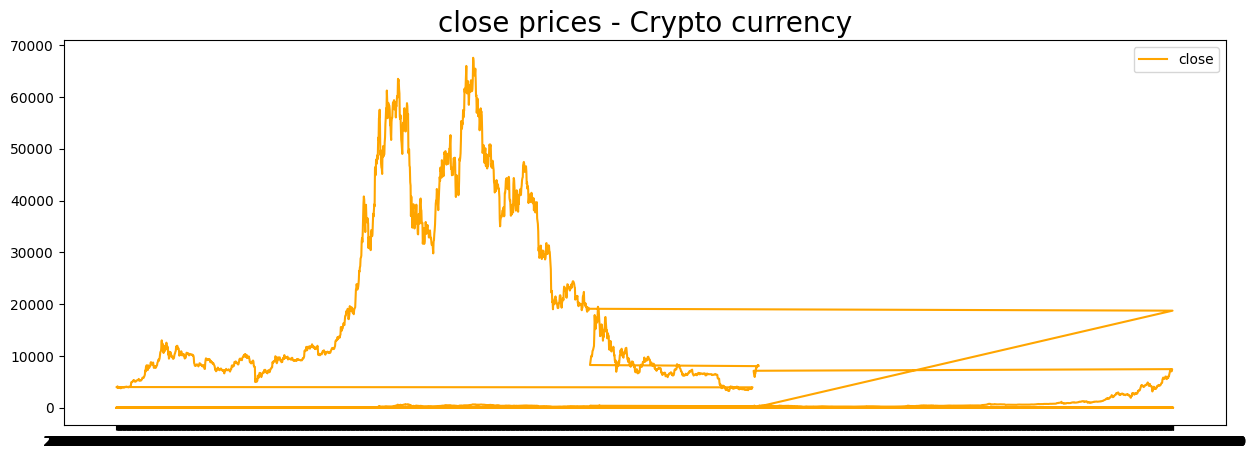

In [ ]:
val_timestamp = df['timestamp'].values
val_close = df['close'].values

plt.figure(figsize=(15,5))


plt.plot(val_timestamp, val_close, label='close', color='orange')
plt.legend()

plt.title('close prices - Crypto currency', fontsize=20)
plt.show()


In [ ]:
df['timestamp'] = pd.to_numeric(pd.to_datetime(df['timestamp']))
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [ ]:
train_data, validation_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)
train_data = train_data.reshape(-1, train_data.shape[1], 1)
train_labels = train_data[:, -1, :]
train_data = train_data[:, :-1, :]
validation_data = validation_data.reshape(-1, validation_data.shape[1], 1)
validation_labels = validation_data[:, -1, :]
validation_data = validation_data[:, :-1, :]

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.1):
        super(EarlyStoppingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_mae = logs.get('mae')
        val_mae = logs.get('val_mae')

        if train_mae is not None and val_mae is not None:
            improvement = (train_mae - val_mae) / train_mae

            if improvement < self.threshold:
                self.model.stop_training = True
                print(f"\nMAE telah terpenuhi < {self.threshold * 100}% skala data.")


In [ ]:
early_stopping_callback = EarlyStoppingCallback(threshold=0.1)
value_learning_rate = 0.001
value_epochs = 100
value_momentum = 0.9

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(60, input_shape=(train_data.shape[1], 1), return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate, momentum=value_momentum)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_data, train_labels, epochs=value_epochs, batch_size=64, validation_data=(validation_data, validation_labels), callbacks=[early_stopping_callback],verbose=2)


Epoch 1/100
202/202 - 7s - loss: 0.0098 - mae: 0.0634 - val_loss: 9.6464e-04 - val_mae: 0.0438 - 7s/epoch - 36ms/step
Epoch 2/100
202/202 - 2s - loss: 0.0092 - mae: 0.0699 - val_loss: 9.6326e-04 - val_mae: 0.0435 - 2s/epoch - 8ms/step
Epoch 3/100
202/202 - 2s - loss: 0.0091 - mae: 0.0686 - val_loss: 9.8825e-04 - val_mae: 0.0439 - 2s/epoch - 8ms/step
Epoch 4/100
202/202 - 2s - loss: 0.0089 - mae: 0.0683 - val_loss: 0.0012 - val_mae: 0.0480 - 2s/epoch - 9ms/step
Epoch 5/100
202/202 - 2s - loss: 0.0088 - mae: 0.0674 - val_loss: 0.0012 - val_mae: 0.0478 - 2s/epoch - 8ms/step
Epoch 6/100
202/202 - 2s - loss: 0.0086 - mae: 0.0663 - val_loss: 0.0013 - val_mae: 0.0483 - 2s/epoch - 8ms/step
Epoch 7/100
202/202 - 2s - loss: 0.0084 - mae: 0.0653 - val_loss: 0.0013 - val_mae: 0.0490 - 2s/epoch - 10ms/step
Epoch 8/100
202/202 - 2s - loss: 0.0083 - mae: 0.0653 - val_loss: 0.0014 - val_mae: 0.0503 - 2s/epoch - 11ms/step
Epoch 9/100
202/202 - 2s - loss: 0.0082 - mae: 0.0645 - val_loss: 0.0016 - val_ma

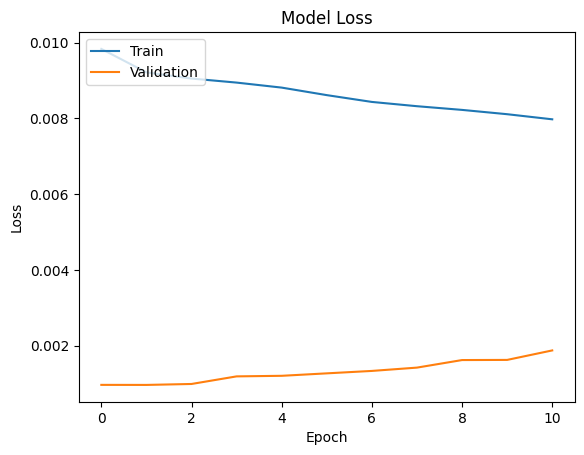

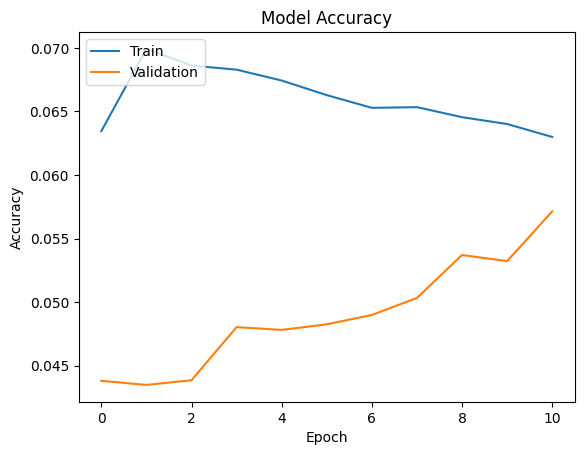

In [ ]:
# Plot loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()